In [13]:
import os
from pathlib import Path
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt
load_dotenv()

PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT")).resolve() # type: ignore
MODEL_ROOT = Path(os.getenv("MODEL_ROOT")).resolve() # type: ignore
IMAGE_ROOT = Path(os.getenv("IMAGE_ROOT")).resolve() # type: ignore
CONFIG_ROOT = Path(os.getenv("CONFIG_ROOT")).resolve() # type: ignore
LOG_ROOT = Path(os.getenv("LOG_ROOT")).resolve() # type: ignore

In [14]:
log_root = LOG_ROOT
log_name = "log.json"
names = []
steps = []
psnrs = []

for sub in sorted(log_root.iterdir()):
    if sub.is_dir():
        if (not (sub / log_name).exists()):
            continue
        names.append(sub.name)
        step = []
        psnr = []
        with open(sub / log_name, "r") as f:
            log_data = json.load(f)
            for k, v in log_data.items():
                step.append(int(k))
                psnr.append(float(v))
        steps.append(step)
        psnrs.append(psnr)

In [15]:
graph_dir = PROJECT_ROOT / "graphs"
os.makedirs(graph_dir, exist_ok=True)

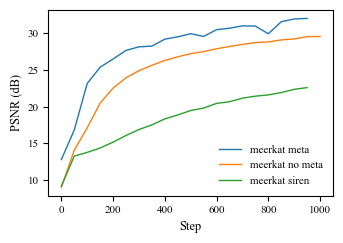

In [16]:
for_paper = True

if for_paper:
    plt.rcParams.update({
        "font.family": "Times New Roman",
        "font.size": 9,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "axes.unicode_minus": False
    })
    figsize = (3.5, 2.5)   # 논문용 작은 사이즈 (inch)
    alpha_raw = 0.15
    lw = 1.0
    add_grid = False
    add_title = False
else:
    figsize = (10, 5)
    alpha_raw = 0.2
    lw = 1.8
    add_grid = True
    add_title = True

plt.figure(figsize=figsize)
for i in range(len(names)):
    label = names[i].replace('_', ' ')
    plt.plot(steps[i], psnrs[i], label=label, color=f"C{i}", linewidth=lw)

plt.savefig(graph_dir / "psnr_to_step.png", dpi=300, bbox_inches='tight')

plt.xlabel('Step')
plt.ylabel('PSNR (dB)')

if add_title:
    plt.title("PSNR vs Step")
if add_grid:
    plt.grid()
plt.legend(frameon=False)

plt.tight_layout()
plt.savefig(graph_dir / "psnr_to_step.png", dpi=300)